# Exploring Data

The purpose of this notebook is to do some preliminary basic data exploration. The goal is to better understand the data. This notebook attemps to answer questions such as how many unique models, how many unique vendors, missing data, correlation of the covariates and label, any intersting patterns in the SMART stats over time, etc.

In [1]:
import os
import gc
import utils
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

import pdb

In [2]:
pbar = ProgressBar()
pbar.register()

In [3]:
# inferred int32 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_11_normalized": "float32",
    "smart_11_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_13_normalized": "float32",
    "smart_13_raw": "float32",
    "smart_15_normalized": "float32",
    "smart_15_raw": "float32",
    "smart_16_normalized": "float32",
    "smart_16_raw": "float32",
    "smart_17_normalized": "float32",
    "smart_17_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_23_normalized": "float32",
    "smart_23_raw": "float32",
    "smart_24_normalized": "float32",
    "smart_24_raw": "float32",
    "smart_168_normalized": "float32",
    "smart_168_raw": "float32",
    "smart_170_normalized": "float32",
    "smart_170_raw": "float32",
    "smart_173_normalized": "float32",
    "smart_173_raw": "float32",
    "smart_174_normalized": "float32",
    "smart_174_raw": "float32",
    "smart_177_normalized": "float32",
    "smart_177_raw": "float32",
    "smart_179_normalized": "float32",
    "smart_179_raw": "float32",
    "smart_181_normalized": "float32",
    "smart_181_raw": "float32",
    "smart_182_normalized": "float32",
    "smart_182_raw": "float32",
    "smart_183_normalized": "float32",
    "smart_183_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_191_normalized": "float32",
    "smart_191_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_195_normalized": "float32",
    "smart_195_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32",
    "smart_200_normalized": "float32",
    "smart_200_raw": "float32",
    "smart_201_normalized": "float32",
    "smart_201_raw": "float32",
    "smart_218_normalized": "float32",
    "smart_218_raw": "float32",
    "smart_220_normalized": "float32",
    "smart_220_raw": "float32",
    "smart_222_normalized": "float32",
    "smart_222_raw": "float32",
    "smart_223_normalized": "float32",
    "smart_223_raw": "float32",
    "smart_224_normalized": "float32",
    "smart_224_raw": "float32",
    "smart_225_normalized": "float32",
    "smart_225_raw": "float32",
    "smart_226_normalized": "float32",
    "smart_226_raw": "float32",
    "smart_231_normalized": "float32",
    "smart_231_raw": "float32",
    "smart_232_normalized": "float32",
    "smart_232_raw": "float32",
    "smart_233_normalized": "float32",
    "smart_233_raw": "float32",
    "smart_235_normalized": "float32",
    "smart_235_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32",
    "smart_250_normalized": "float32",
    "smart_250_raw": "float32",
    "smart_251_normalized": "float32",
    "smart_251_raw": "float32",
    "smart_252_normalized": "float32",
    "smart_252_raw": "float32",
    "smart_254_normalized": "float32",
    "smart_254_raw": "float32",
    "smart_255_normalized": "float32",
    "smart_255_raw": "float32",
}

In [4]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
# TODO: move to reading from Ceph after slow read blocker is removed
DATA_ROOT_DIR = '/home/kachauha/Downloads/'
df4 = dd.read_csv(os.path.join(DATA_ROOT_DIR, 'data_Q4_2018', '*.csv'), dtype=custom_dtypes)
df3 = dd.read_csv(os.path.join(DATA_ROOT_DIR, 'data_Q3_2018', '*.csv'), dtype=custom_dtypes)
df = utils.optimal_repartition_df(dd.concat(dfs=[df3, df4], interleave_partitions=True))
# df = dd.read_csv(
#     "s3://DH-PLAYPEN/kachauha/*/*.csv",
#     storage_options={
#         "client_kwargs": {"endpoint_url": "https://s3.upshift.redhat.com/"}
#     },
#     dtype=custom_dtypes
# )

[########################################] | 100% Completed |  1min 47.2s


In [5]:
# models that each serial number belongs to for seagate
seagate_df = df[df['model'].str.startswith('S')]
ser_models = seagate_df[['serial_number', 'model']]\
                    .drop_duplicates(subset='serial_number', keep='last')\
                    .compute()
ser_models.head()

[########################################] | 100% Completed |  1min 27.3s


,serial_number,model
8963,ZA12624Y,ST8000DM002
70357,S300Z4Y3,ST4000DM000
4285,Z300K1Z7,ST4000DM000
99943,W300L6AL,ST4000DM000
41,Z300X922,ST4000DM000


In [6]:
# number of drives of a model as a cumulative percentage of total number of drives
ser_models['model'].value_counts().sort_values(ascending=False).cumsum() / ser_models.shape[0]

ST12000NM0007                          0.367582
ST4000DM000                            0.678912
ST8000NM0055                           0.842178
ST8000DM002                            0.954206
ST6000DX000                            0.975392
ST10000NM0086                          0.989260
ST500LM012 HN                          0.996544
ST500LM030                             0.997877
ST4000DM005                            0.998690
ST8000DM005                            0.998984
ST9250315AS                            0.999164
ST6000DM001                            0.999334
ST9320325AS                            0.999492
Seagate BarraCuda SSD ZA500CM10002     0.999639
ST320LT007                             0.999729
ST8000DM004                            0.999797
ST3160316AS                            0.999864
ST250LM004 HN                          0.999921
ST6000DM004                            0.999955
ST3160318AS                            0.999977
Seagate BarraCuda SSD ZA2000CM10002    0

## Summaries

In [48]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
failed_serials = df[df['failure']==1][['model', 'serial_number']].compute()
print(failed_serials.shape)
failed_serials.head()

[########################################] | 100% Completed |  1min 12.3s
(749, 2)


,model,serial_number
8963,ST8000DM002,ZA12624Y
70357,ST4000DM000,S300Z4Y3
4285,ST4000DM000,Z300K1Z7
26936,TOSHIBA MQ01ABF050,96ICTBQMT
99943,ST4000DM000,W300L6AL


In [11]:
# get the serial numbers for all the failed hard drives, date of failure, and its model
# multiple entries will exist per serial number since it will be a time series. get only the last one
working_serials = df[~df['serial_number'].isin(failed_serials['serial_number'])][['serial_number', 'model']]\
                    .drop_duplicates(subset='serial_number', keep='last')\
                    .compute()
print(working_serials.shape)
working_serials.head()

[########################################] | 100% Completed |  1min 31.4s
(113724, 2)


,serial_number,model
41,Z300X922,ST4000DM000
89,Z4D07B6E,ST6000DX000
345,Z3016SX0,ST4000DM000
376,Z300WG7R,ST4000DM000
620,6VDHZB43,ST9320325AS


In [12]:
# sanity check - make sure we havent labelled a serial number as BOTH working and failed
working_serials['serial_number'].isin(failed_serials['serial_number']).any()

False

In [22]:
# are there any specific models that failed more so than the others?
model_stats = pd.merge(failed_serials['model'].value_counts().to_frame('failed_count').reset_index(),
                        working_serials['model'].value_counts().to_frame('working_count').reset_index(),
                        how='outer').fillna(0)

# rename the index column as the model column
model_stats.rename(columns={'index': 'model'}, inplace=True)

# # sanity check - did the merge include all the observations or did it drop any?
# (foo['index'].isin(tmp['index'])).all() and (bar['index'].isin(tmp['index']).all())    # True

# percentage of instances that have failed, per model
model_stats['fail_percent'] = model_stats['failed_count'] / (model_stats['failed_count'] + model_stats['working_count'])
model_stats

,model,failed_count,working_count,fail_percent
0,ST4000DM000,269.0,27299,0.009758
1,ST12000NM0007,208.0,32341,0.006390
2,ST8000NM0055,74.0,14383,0.005119
3,ST8000DM002,46.0,9874,0.004637
4,HGST HMS5C4040BLE640,28.0,15029,0.001860
5,TOSHIBA MQ01ABF050,28.0,525,0.050633
6,ST500LM012 HN,21.0,624,0.032558
7,ST6000DX000,12.0,1864,0.006397
8,HGST HMS5C4040ALE640,11.0,4957,0.002214
9,WDC WD5000LPVX,11.0,292,0.036304


**NOTE** Although there are 48 different models of hard drives being used, these are coming from only 5 unique vendors. The values of SMART stats and whether or not they are reported varies from vendor to vendor. Furthermore, simply including vendor as a feature may or may not work for all kinds of prediction models. Therefore, it may be a good idea to analyze the data in a vendor specific way.

In [9]:
# split data into the 5 vendors - seagate, wdc, hgst, hitachi, toshiba
wdc_df = df[df['model'].str.startswith('W')]
hgst_df = df[df['model'].str.startswith('HG')]
toshiba_df = df[df['model'].str.startswith('T')]
seagate_df = df[df['model'].str.startswith('S')]
hitachi_df = df[df['model'].str.startswith('Hi')]

In [15]:
# get number of hard drives per vendor
print(wdc_df['serial_number'].nunique().compute())
print(hgst_df['serial_number'].nunique().compute())
print(toshiba_df['serial_number'].nunique().compute())
print(seagate_df['serial_number'].nunique().compute())
print(hitachi_df['serial_number'].nunique().compute())

[########################################] | 100% Completed |  1min 24.0s
1068
[########################################] | 100% Completed |  1min 24.5s
22455
[########################################] | 100% Completed |  1min 24.2s
2381
[########################################] | 100% Completed |  1min 24.4s
88549
[########################################] | 100% Completed |  1min 23.5s
19


In [31]:
# how many from each vendor do we have
# save shape because it will be used again - calculating again takes long
wdc_df_shape = dd.compute(wdc_df.shape)[0]
print(wdc_df_shape)
hgst_df_shape = dd.compute(hgst_df.shape)[0]
print(hgst_df_shape)
toshiba_df_shape = dd.compute(toshiba_df.shape)[0]
print(toshiba_df_shape)
seagate_df_shape = dd.compute(seagate_df.shape)[0]
print(seagate_df_shape)
hitachi_df_shape = dd.compute(hitachi_df.shape)[0]
print(hitachi_df_shape)

[########################################] | 100% Completed |  1min 28.2s
(153542, 129)
[########################################] | 100% Completed |  1min 29.0s
(3840378, 129)
[########################################] | 100% Completed |  1min 25.2s
(307181, 129)
[########################################] | 100% Completed |  1min 27.6s
(14302746, 129)
[########################################] | 100% Completed |  1min 23.6s
(2961, 129)


In [32]:
# same goes for the shape of the entire df
df_shape = dd.compute(df.shape[0])[0]

[########################################] | 100% Completed |  1min 17.9s


In [23]:
# model_stats[model_stats['model'].str.startswith('S')]['vendor'] = 'Seagate'    
model_stats['vendor'] = model_stats['model'].apply(utils.get_vendor)
model_stats.head()

,model,failed_count,working_count,fail_percent,vendor
0,ST4000DM000,269.0,27299,0.009758,Seagate
1,ST12000NM0007,208.0,32341,0.006390,Seagate
2,ST8000NM0055,74.0,14383,0.005119,Seagate
3,ST8000DM002,46.0,9874,0.004637,Seagate
4,HGST HMS5C4040BLE640,28.0,15029,0.001860,HGST


In [24]:
# get vendor-wise stats for failed vs working
vendor_stats = model_stats.groupby('vendor').sum()
vendor_stats['fail_percent'] = vendor_stats['failed_count'] / (vendor_stats['failed_count'] + vendor_stats['working_count'])
vendor_stats

,failed_count,working_count,fail_percent
vendor,,,
HGST,41.0,22414,0.001826
Hitachi,0.0,19,0.000000
Seagate,645.0,87905,0.007284
Toshiba,42.0,2339,0.017640
WDC,21.0,1047,0.019663


In [19]:
# TODO: should we create a corr matrix for model vs failure or would it lead to misinterpretation of information

## Analyze Critical Stats

These are the columns specified by wikipedia, backblaze, and IBM research as good predictors.

1. Backblaze mentions five stats as better predictors than others. These are 5, 187, 188, 197, 198.They also provide some [analysis](https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/) using these features.

2. IBM published a [paper](https://www.kdd.org/kdd2016/papers/files/adf0849-botezatuA.pdf) regarding drive failure prediction as well.

3. Wikipedia also [mentions](https://en.wikipedia.org/wiki/S.M.A.R.T.#ATA_S.M.A.R.T._attributes) some predictors as critical.

In [7]:
CRITICAL_STATS = [1, 5, 7, 10, 184, 187, 188, 189, 190, 193, 194, 196, 197, 198, 201, 240, 241, 242]

# NOTE - THESE LISTS ARE SUBJECT TO CHANGE
crit_cols_raw = ['smart_{}_raw'.format(i) for i in CRITICAL_STATS]
crit_cols_normalized = ['smart_{}_normalized'.format(i) for i in CRITICAL_STATS]

### SMART Stats Descriptions
Source: Wikipedia

Putting descriptions here to help better make sense of the results that follow.

184 = end to end error / ioedc : This attribute is a part of Hewlett-Packard's SMART IV technology, as well as part of other vendors' IO Error Detection and Correction schemas, and it contains a count of parity errors which occur in the data path to the media via the drive's cache RAM.

187 = reported uncorrectable errors : The count of errors that could not be recovered using hardware ECC (see attribute 195)

188 = command timeout : The count of aborted operations due to HDD timeout. Normally this attribute value should be equal to zero.

189 = high fly write : This feature is implemented in most modern Seagate drives and some of Western Digital's drives, beginning with the WD Enterprise WDE18300 and WDE9180 Ultra2 SCSI hard drives, and will be included on all future WD Enterprise products.

190 = temp diff / airflow diff : Value is equal to (100-temp. °C), allowing manufacturer to set a minimum threshold which corresponds to a maximum temperature. This also follows the convention of 100 being a best-case value and lower values being undesirable. However, some older drives may instead report raw Temperature (identical to 0xC2) or Temperature minus 50 here.

196 = reallocation event count : Count of remap operations. The raw value of this attribute shows the total count of attempts to transfer data from reallocated sectors to a spare area. Both successful and unsuccessful attempts are counted

201 = soft read eror rate or TA counter detected : Count indicates the number of uncorrectable software read errors.

### NaN Counts

In [12]:
# number of nans
print('All data')
nan_count = utils.get_nan_count_percent(df[crit_cols_raw + crit_cols_normalized], df_shape[0]).compute()
nan_count

All data
[########################################] | 100% Completed |  1min 11.4s
[########################################] | 100% Completed |  1min 10.0s


,count,percent
smart_1_raw,447,0.000024
smart_5_raw,947,0.000051
smart_7_raw,947,0.000051
smart_10_raw,947,0.000051
smart_184_raw,9087967,0.488422
smart_187_raw,4417004,0.237386
smart_188_raw,4417004,0.237386
smart_189_raw,9087967,0.488422
smart_190_raw,4417004,0.237386
smart_193_raw,114087,0.006131


Some vendors may not provide certain SMART stats. This could be one possible explanation for the high number of nans. If this is the case, then that particular feature will not be helpful for predicting status of a drive from that vendor. Lets get the vendor-wise nans

In [26]:
print('Seagate')
seagate_nan_ct = utils.get_nan_count_percent(seagate_df[crit_cols_raw + crit_cols_normalized], seagate_df_shape[0]).compute()
seagate_nan_ct

Seagate
[########################################] | 100% Completed |  1min 29.6s
[########################################] | 100% Completed |  1min 27.2s


,count,percent
smart_1_raw,367,0.000026
smart_5_raw,867,0.000061
smart_7_raw,867,0.000061
smart_10_raw,867,0.000061
smart_184_raw,4783905,0.334475
smart_187_raw,112942,0.007897
smart_188_raw,112942,0.007897
smart_189_raw,4783905,0.334475
smart_190_raw,112942,0.007897
smart_193_raw,114007,0.007971


In [34]:
print('WDC')
wdc_nan_ct = utils.get_nan_count_percent(wdc_df[crit_cols_raw + crit_cols_normalized], wdc_df_shape[0]).compute()
wdc_nan_ct

WDC
[########################################] | 100% Completed |  1min 17.6s


,count,percent
smart_1_raw,0,0.000000
smart_5_raw,0,0.000000
smart_7_raw,0,0.000000
smart_10_raw,0,0.000000
smart_184_raw,153542,1.000000
smart_187_raw,153542,1.000000
smart_188_raw,153542,1.000000
smart_189_raw,153542,1.000000
smart_190_raw,153542,1.000000
smart_193_raw,0,0.000000


In [35]:
print('HGST')
hgst_nan_ct = utils.get_nan_count_percent(hgst_df[crit_cols_raw + crit_cols_normalized], hgst_df_shape[0]).compute()
hgst_nan_ct

HGST
[########################################] | 100% Completed |  1min 16.6s


,count,percent
smart_1_raw,75,0.00002
smart_5_raw,75,0.00002
smart_7_raw,75,0.00002
smart_10_raw,75,0.00002
smart_184_raw,3840378,1.00000
smart_187_raw,3840378,1.00000
smart_188_raw,3840378,1.00000
smart_189_raw,3840378,1.00000
smart_190_raw,3840378,1.00000
smart_193_raw,75,0.00002


In [36]:
print('Hitachi')
hitachi_nan_ct = utils.get_nan_count_percent(hitachi_df[crit_cols_raw + crit_cols_normalized], hitachi_df_shape[0]).compute()
hitachi_nan_ct

Hitachi
[########################################] | 100% Completed |  1min 14.7s


,count,percent
smart_1_raw,0,0.0
smart_5_raw,0,0.0
smart_7_raw,0,0.0
smart_10_raw,0,0.0
smart_184_raw,2961,1.0
smart_187_raw,2961,1.0
smart_188_raw,2961,1.0
smart_189_raw,2961,1.0
smart_190_raw,2961,1.0
smart_193_raw,0,0.0


In [37]:
print('Toshiba')
toshiba_nan_ct = utils.get_nan_count_percent(toshiba_df[crit_cols_raw + crit_cols_normalized], toshiba_df_shape[0]).compute()
toshiba_nan_ct

Toshiba
[########################################] | 100% Completed |  1min 15.8s


,count,percent
smart_1_raw,5,0.000016
smart_5_raw,5,0.000016
smart_7_raw,5,0.000016
smart_10_raw,5,0.000016
smart_184_raw,307181,1.000000
smart_187_raw,307181,1.000000
smart_188_raw,307181,1.000000
smart_189_raw,307181,1.000000
smart_190_raw,307181,1.000000
smart_193_raw,5,0.000016


### NOTE: are the nans meaningless or do they imply 0?
This will be analyzed in the `data_cleaner_*.ipynb` notebooks.

In [34]:
# general description
# NOTE: the columns with all values NAN must be removed otherwise a value error is thrown
summary = df[nan_count.index[nan_count['percent'] != 1]].describe().compute()
summary

[########################################] | 100% Completed |  1min 27.1s


,smart_1_raw,smart_5_raw,smart_7_raw,smart_10_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,smart_193_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_196_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
count,1.860636e+07,1.860586e+07,1.860586e+07,1.860586e+07,9.518841e+06,1.418980e+07,1.418980e+07,9.518841e+06,1.418980e+07,1.849272e+07,...,9.518841e+06,1.418980e+07,1.849272e+07,1.860636e+07,4.416057e+06,1.860586e+07,1.860586e+07,1.450992e+07,1.419016e+07,1.419016e+07
mean,9.307346e+07,5.079427e+00,1.886651e+09,2.033196e+01,5.379647e-03,7.462168e-02,7.587353e+07,8.279002e+00,2.862568e+01,1.590091e+04,...,9.891187e+01,7.137433e+01,9.385218e+01,6.843964e+01,1.073184e+02,1.017370e+02,1.009370e+02,9.996014e+01,1.000130e+02,1.000130e+02
std,8.050941e+07,2.916761e+02,1.621473e+11,1.651140e+03,3.941210e-01,1.763510e+01,3.308769e+09,5.883149e+02,6.468517e+00,4.642846e+04,...,5.625491e+00,6.468517e+00,1.827117e+01,7.500026e+01,2.968084e+01,1.476848e+01,1.185070e+01,1.303219e+00,1.140496e+00,1.140496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,1.000000e+00,...,1.000000e+00,4.400000e+01,1.000000e+00,1.400000e+01,1.000000e+00,1.000000e+00,1.000000e+00,3.200000e+01,1.000000e+02,1.000000e+02
25%,6.733272e+06,0.000000e+00,5.505044e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.600000e+01,3.850000e+02,...,1.000000e+02,6.800000e+01,9.500000e+01,2.700000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
50%,8.764186e+07,0.000000e+00,4.137496e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,3.079000e+03,...,1.000000e+02,7.400000e+01,1.000000e+02,3.300000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
75%,1.688201e+08,0.000000e+00,9.788020e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.500000e+01,1.402650e+04,...,1.000000e+02,7.800000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02
max,8.449025e+08,6.501600e+04,2.814707e+14,3.276800e+05,7.200000e+01,6.553500e+04,6.013057e+11,6.553500e+04,5.600000e+01,1.104852e+06,...,1.000000e+02,8.600000e+01,2.000000e+02,2.530000e+02,2.520000e+02,2.520000e+02,2.520000e+02,1.000000e+02,2.000000e+02,2.000000e+02


In [17]:
# number of rows to use for plotting - sampling is done iff number of rows is too much to keep in memory
num_rows_to_sample = 5000000

[########################################] | 100% Completed |  1min 20.7s
120 out of 5000001 are NaN values. These are not shown on the graph below


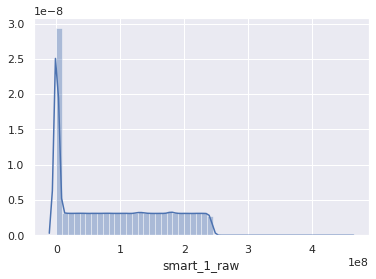

[########################################] | 100% Completed |  1min 10.5s
252 out of 5000001 are NaN values. These are not shown on the graph below


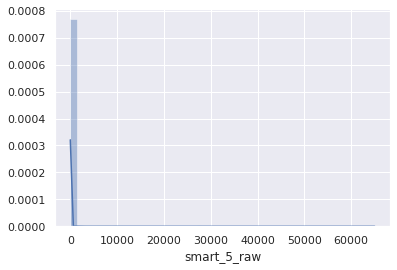

[########################################] | 100% Completed |  1min 10.8s
236 out of 5000001 are NaN values. These are not shown on the graph below


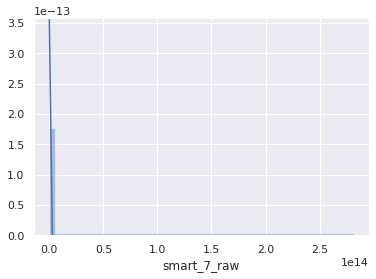

[########################################] | 100% Completed |  1min 10.5s
269 out of 5000001 are NaN values. These are not shown on the graph below


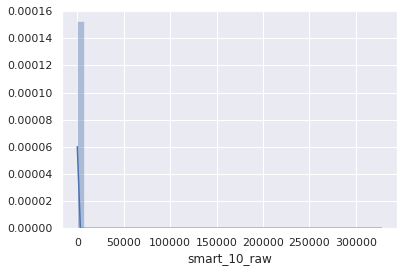

[########################################] | 100% Completed |  1min 11.0s
1188459 out of 5000001 are NaN values. These are not shown on the graph below


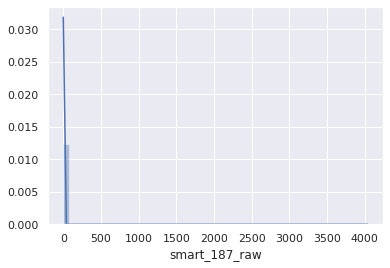

[########################################] | 100% Completed |  1min 10.3s
1187034 out of 5000001 are NaN values. These are not shown on the graph below


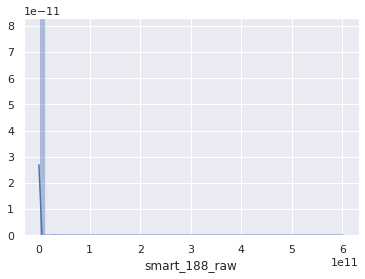

[########################################] | 100% Completed |  1min 10.1s
1187852 out of 5000001 are NaN values. These are not shown on the graph below


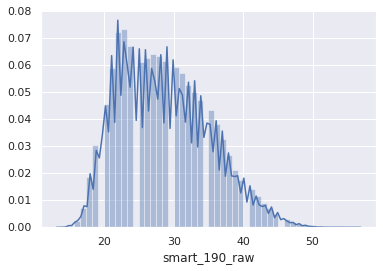

[########################################] | 100% Completed |  1min 10.5s
30615 out of 5000001 are NaN values. These are not shown on the graph below


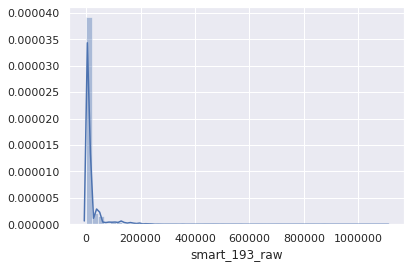

[########################################] | 100% Completed |  1min 10.4s
137 out of 5000001 are NaN values. These are not shown on the graph below


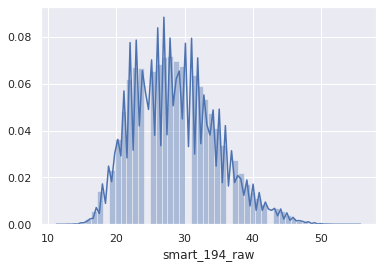

[########################################] | 100% Completed |  1min 10.6s
251 out of 5000001 are NaN values. These are not shown on the graph below


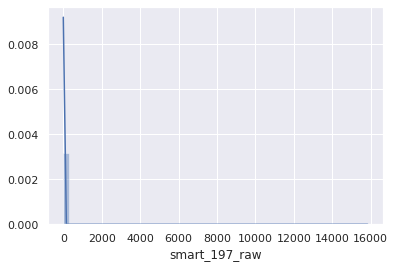

[########################################] | 100% Completed |  1min 10.5s
245 out of 5000001 are NaN values. These are not shown on the graph below


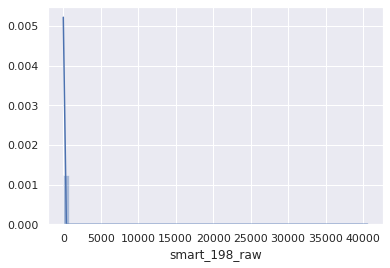

[########################################] | 100% Completed |  1min 10.3s
1101800 out of 5000001 are NaN values. These are not shown on the graph below


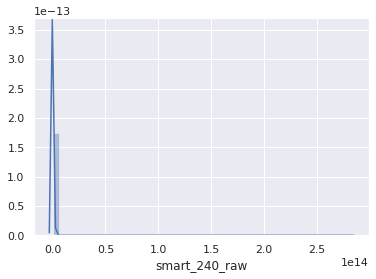

[########################################] | 100% Completed |  1min 10.4s
1187299 out of 5000001 are NaN values. These are not shown on the graph below


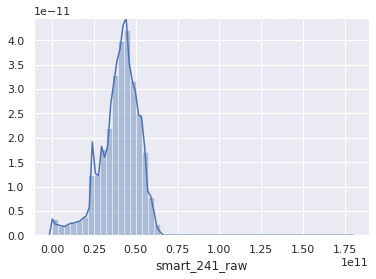

[########################################] | 100% Completed |  1min 10.5s
1185768 out of 5000001 are NaN values. These are not shown on the graph below


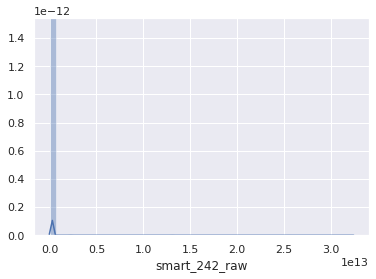

[########################################] | 100% Completed |  1min 10.5s
122 out of 5000001 are NaN values. These are not shown on the graph below


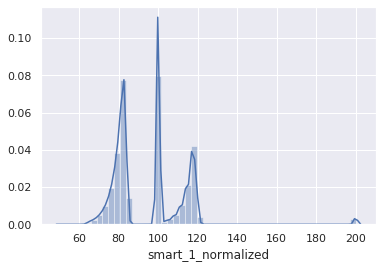

[########################################] | 100% Completed |  1min 14.8s
239 out of 5000001 are NaN values. These are not shown on the graph below


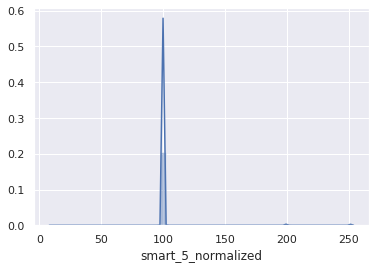

[########################################] | 100% Completed |  1min 36.3s
235 out of 5000001 are NaN values. These are not shown on the graph below


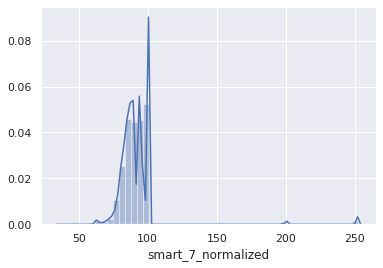

[########################################] | 100% Completed |  1min 18.6s
245 out of 5000001 are NaN values. These are not shown on the graph below


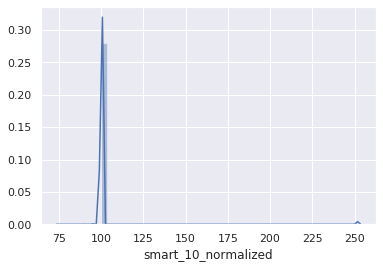

[########################################] | 100% Completed |  1min 26.1s
1186450 out of 5000001 are NaN values. These are not shown on the graph below


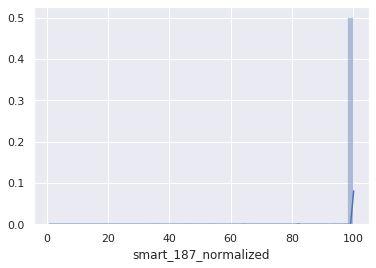

[########################################] | 100% Completed |  1min  9.5s
1186393 out of 5000001 are NaN values. These are not shown on the graph below


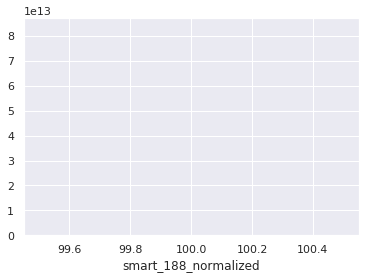

[########################################] | 100% Completed |  1min  7.8s
1186454 out of 5000001 are NaN values. These are not shown on the graph below


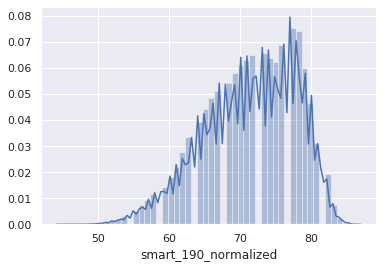

[########################################] | 100% Completed |  1min  7.9s
30587 out of 5000001 are NaN values. These are not shown on the graph below


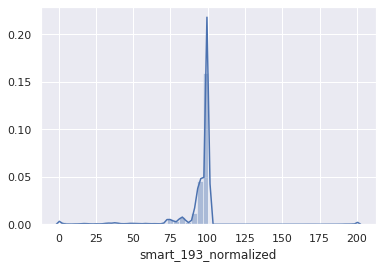

[########################################] | 100% Completed |  1min  8.3s
96 out of 5000001 are NaN values. These are not shown on the graph below


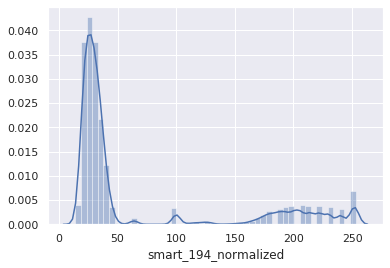

[########################################] | 100% Completed |  1min  8.0s
260 out of 5000001 are NaN values. These are not shown on the graph below


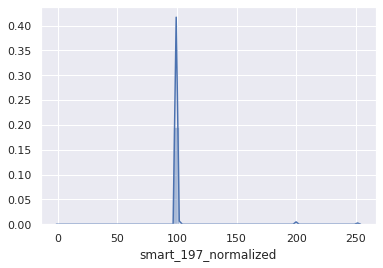

[########################################] | 100% Completed |  1min  8.1s
254 out of 5000001 are NaN values. These are not shown on the graph below


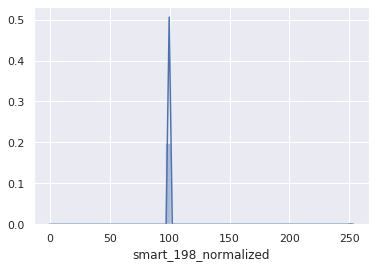

[########################################] | 100% Completed |  1min  7.4s
1101301 out of 5000001 are NaN values. These are not shown on the graph below


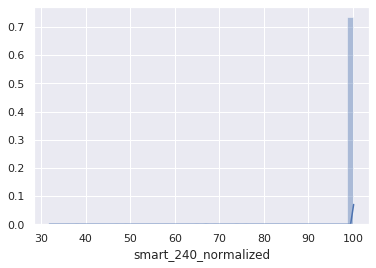

[########################################] | 100% Completed |  1min  8.1s
1188339 out of 5000001 are NaN values. These are not shown on the graph below


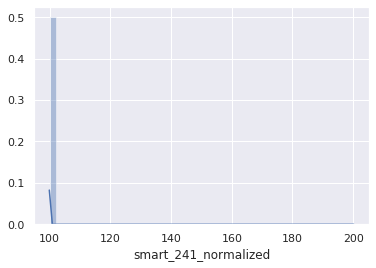

[########################################] | 100% Completed |  1min  7.8s
1186600 out of 5000001 are NaN values. These are not shown on the graph below


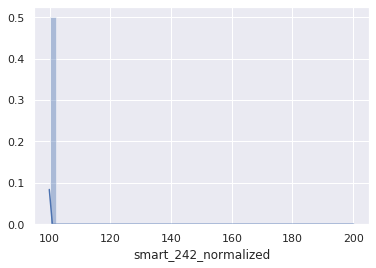

In [68]:
# plot histograms for overall data
# it would probably be more insightful to do this per vendor, but start with overall
# dont make the hist if all values are nan
hist_cols = nan_count.index[nan_count['percent'] < 0.25]    # + ['failure', 'capacity_bytes']
for col in hist_cols:
    # get all the values for this column
    if num_rows_to_sample < df_shape[0]:
        data = df[col].sample(frac=num_rows_to_sample/df_shape[0]).compute()
    else:
        data = df[col].compute()

    # plot only the non null values
    print(data.isna().sum(), 'out of', data.shape[0], 'are NaN values. These are not shown on the graph below')
    sns.distplot(data[~data.isna()])
    plt.show()

[########################################] | 100% Completed |  6min  1.2s


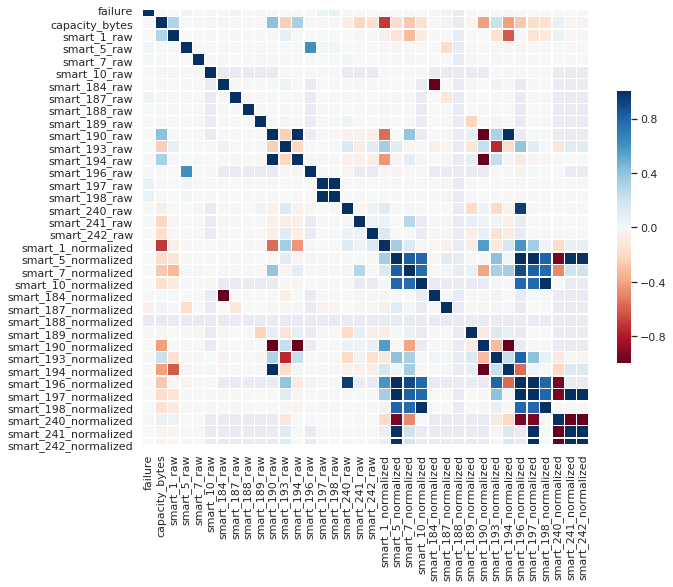

In [20]:
# correlation with failure
# corr_cols = ['failure', 'capacity_bytes'] + crit_cols_raw + crit_cols_normalized
corr_cols = ['failure', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] != 1])
corr_mat = df[corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_mat,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

In [21]:
# only those attributes with less than NAN_PERCENT_THRESHOLD% values as NaN's
# will be selected for computing the correaltion matirx
NAN_PERCENT_THRESHOLD = 0.5

[########################################] | 100% Completed |  4min 29.1s


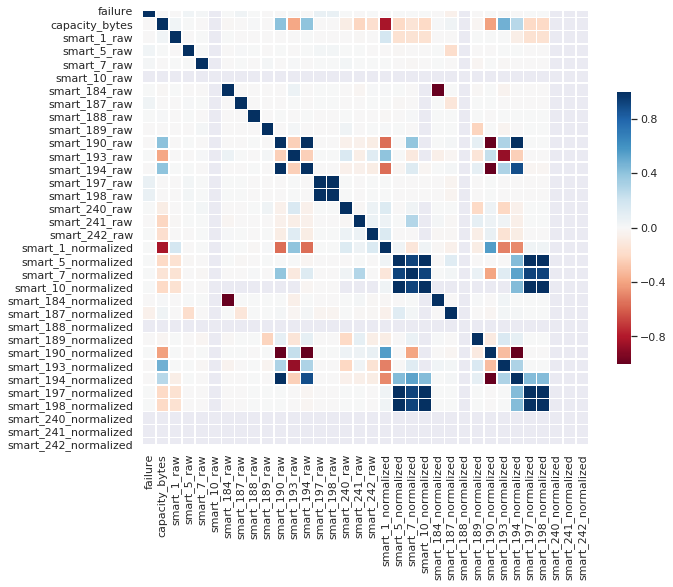

In [27]:
# correlation matrix for seagaet drives
seagate_corr_cols = ['failure', 'capacity_bytes']  + list(seagate_nan_ct.index[seagate_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
seagate_corr = seagate_df[seagate_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(seagate_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min 24.8s


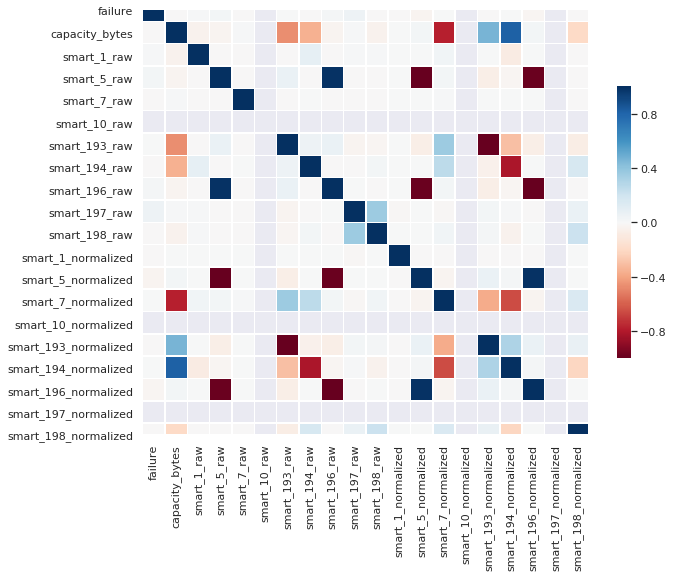

In [38]:
# correlation matrix for wdc drives
wdc_corr_cols = ['failure', 'capacity_bytes'] + list(wdc_nan_ct.index[wdc_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
wdc_corr = wdc_df[wdc_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(wdc_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min 35.5s


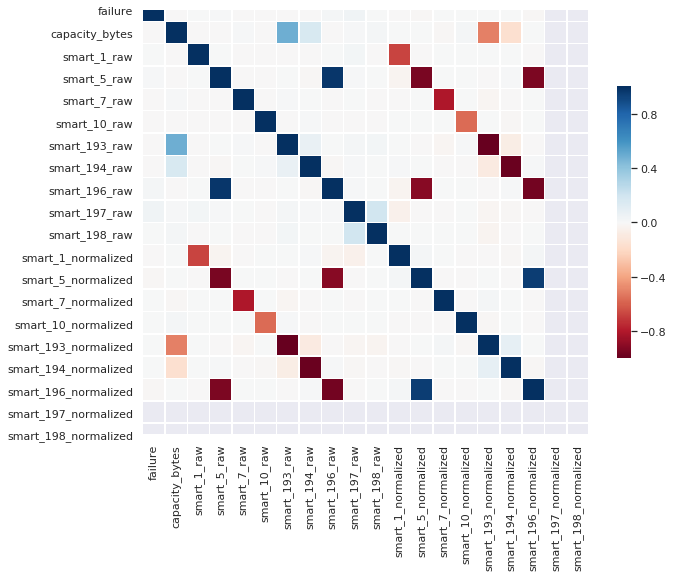

In [39]:
# correlation matrix for hgst drives
hgst_corr_cols = ['failure', 'capacity_bytes'] + list(hgst_nan_ct.index[hgst_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hgst_corr = hgst_df[hgst_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hgst_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min 31.3s


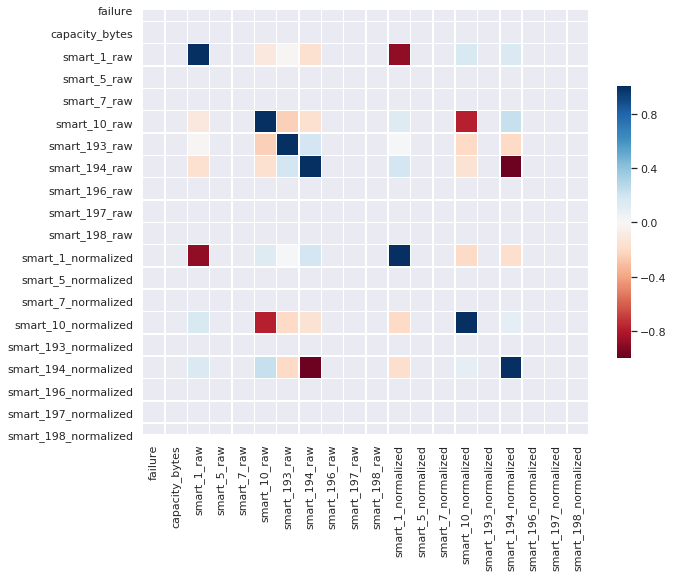

In [40]:
# correlation matrix for hitachi drives
hitachi_corr_cols = ['failure', 'capacity_bytes'] + list(hitachi_nan_ct.index[hitachi_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
hitachi_corr = hitachi_df[hitachi_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hitachi_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

[########################################] | 100% Completed |  1min 29.9s


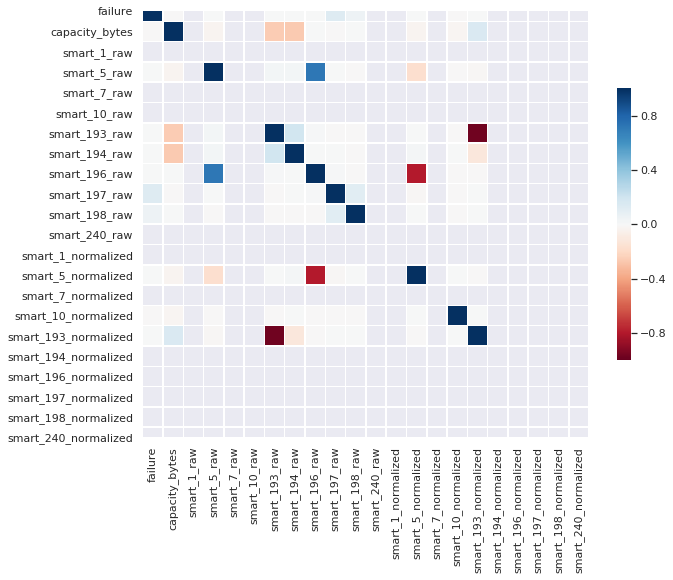

In [41]:
# correlation matrix for toshiba drives
toshiba_corr_cols = ['failure', 'capacity_bytes'] + list(toshiba_nan_ct.index[toshiba_nan_ct['percent'] < NAN_PERCENT_THRESHOLD])
toshiba_corr = toshiba_df[toshiba_corr_cols].corr().compute()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(toshiba_corr,
            ax=ax,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=.5,
            cmap='RdBu',
            cbar_kws={"shrink": .5})

1 / 50. Drive serial number 175PP3I7T
[########################################] | 100% Completed |  1min 11.8s
2 / 50. Drive serial number S2ZYJ9CFC01460
[########################################] | 100% Completed |  1min 12.7s
3 / 50. Drive serial number Z4D0D1V1
[########################################] | 100% Completed |  1min 12.4s
4 / 50. Drive serial number Z304JMAM
[########################################] | 100% Completed |  1min 11.4s
5 / 50. Drive serial number ZJV03CQH
[########################################] | 100% Completed |  1min 11.9s
6 / 50. Drive serial number 88Q0A01NF97G
[########################################] | 100% Completed |  1min 11.9s
7 / 50. Drive serial number ZA181AA1
[########################################] | 100% Completed |  1min 11.7s
8 / 50. Drive serial number Z3025KZQ
[########################################] | 100% Completed |  1min 11.9s
9 / 50. Drive serial number S301PQF4
[########################################] | 100% Completed |  1

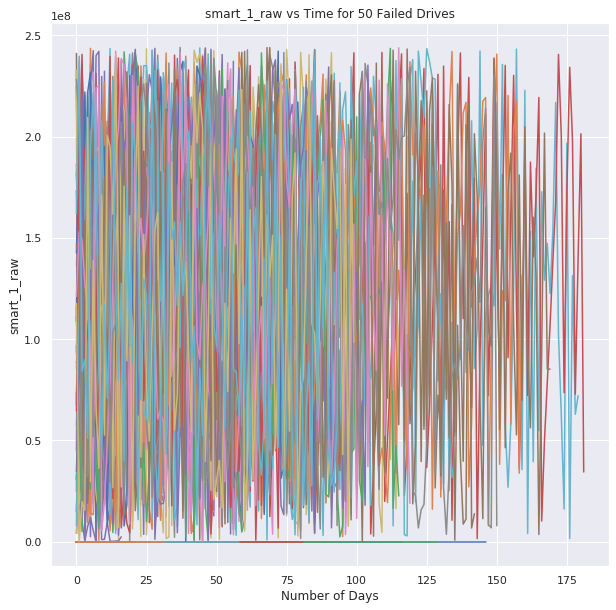

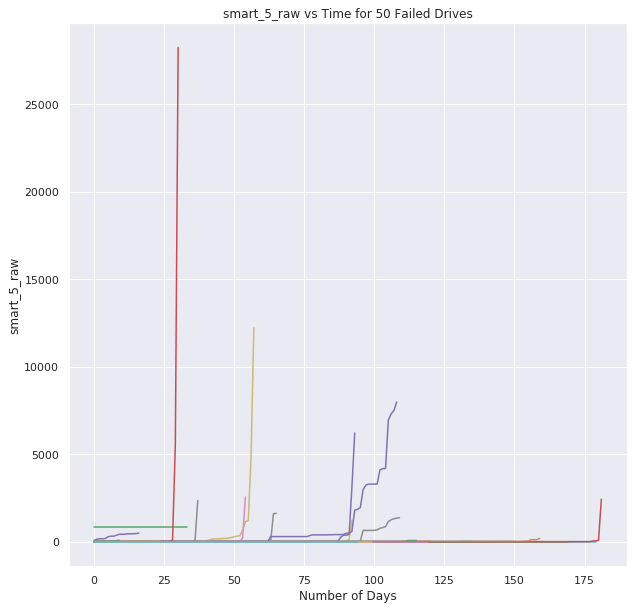

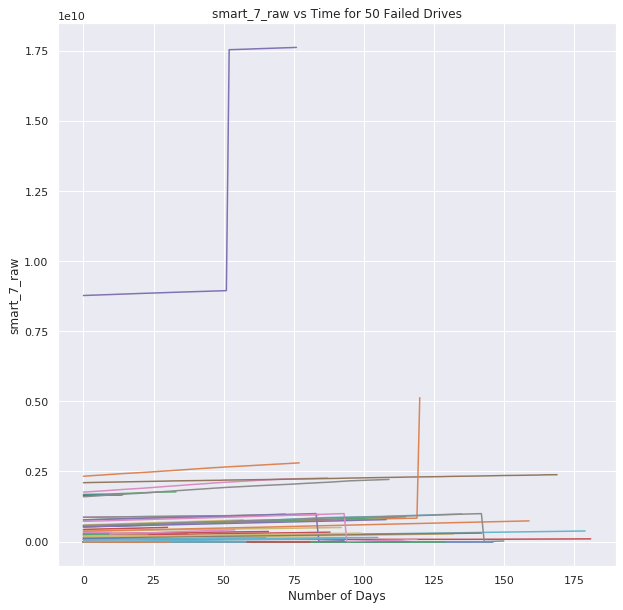

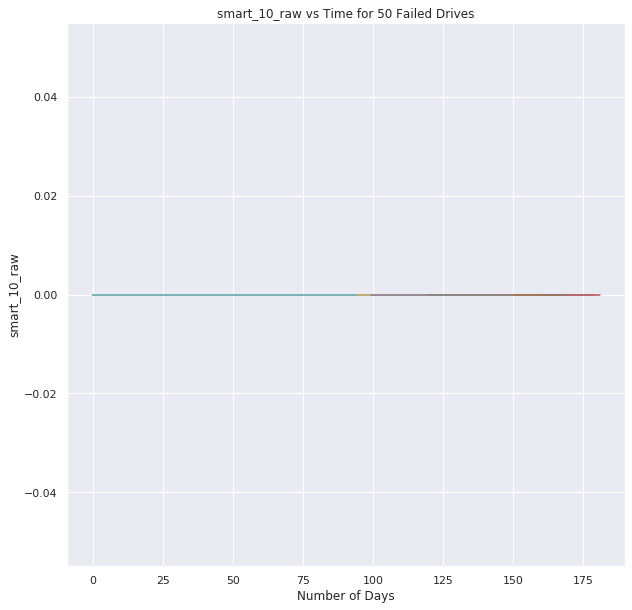

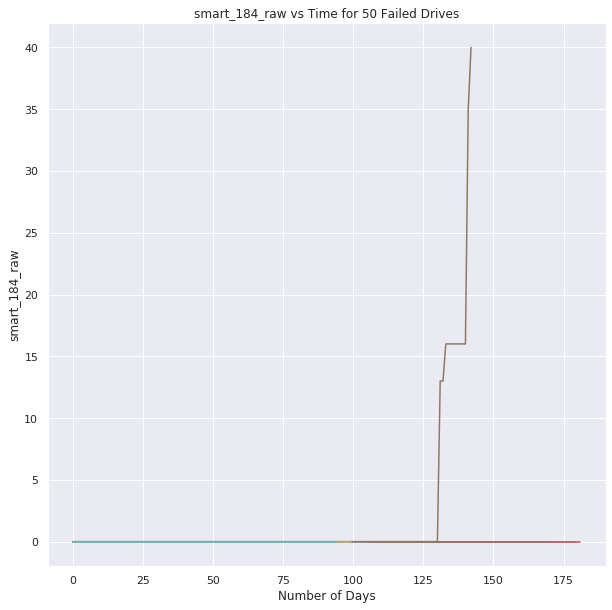

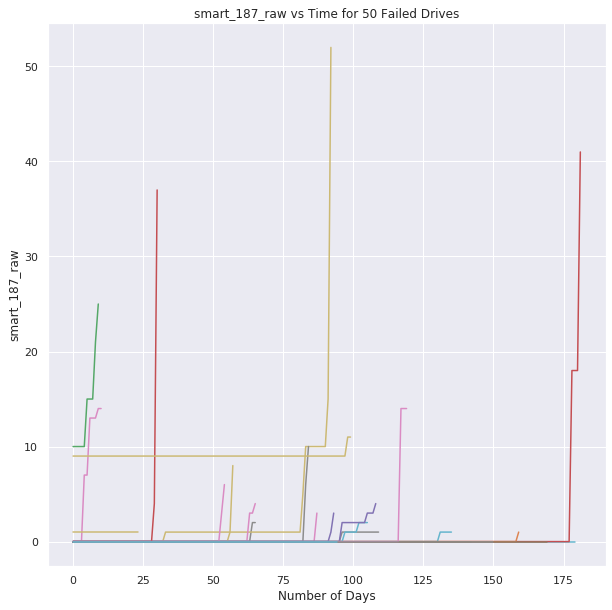

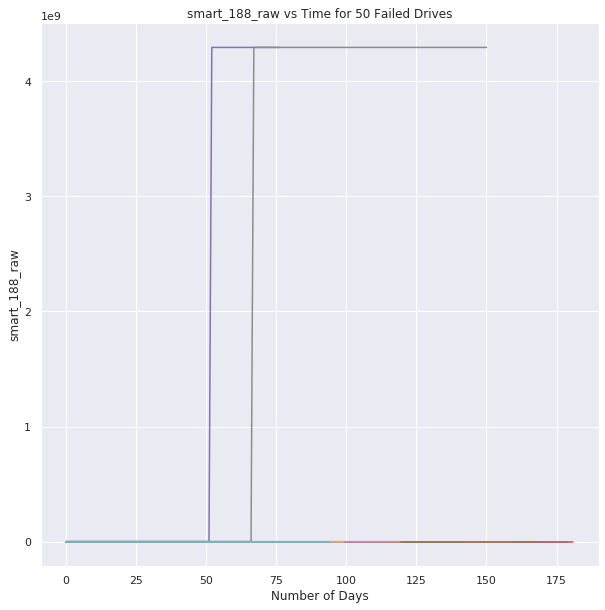

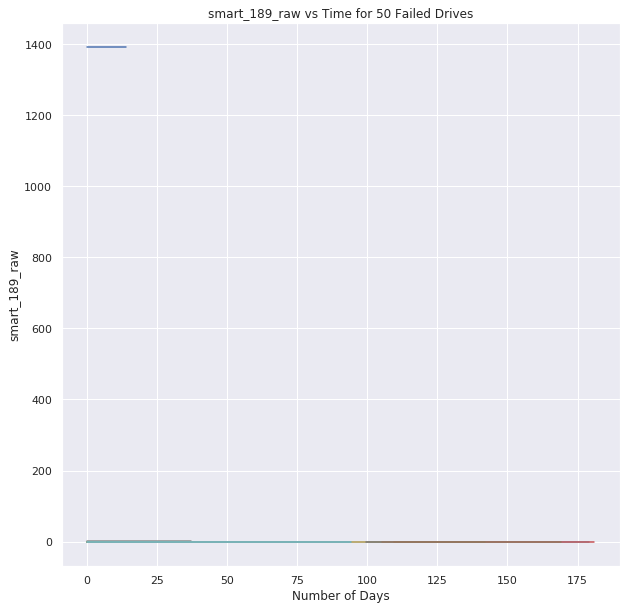

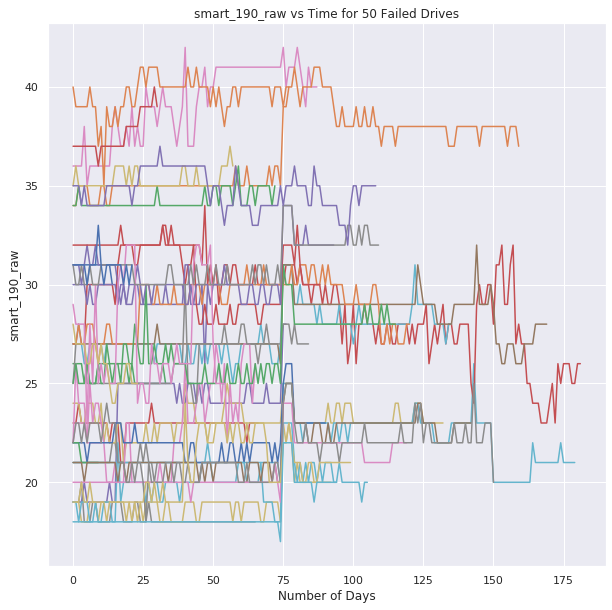

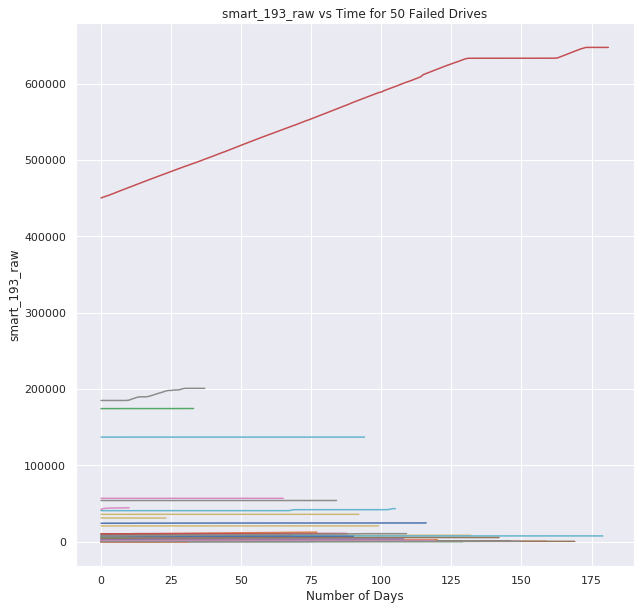

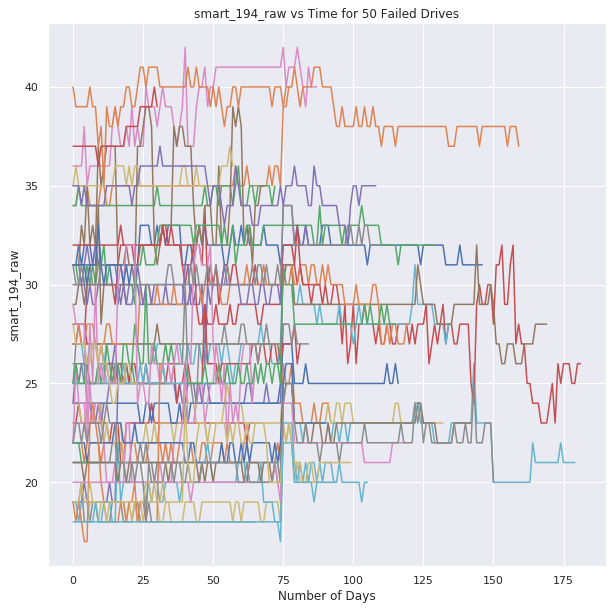

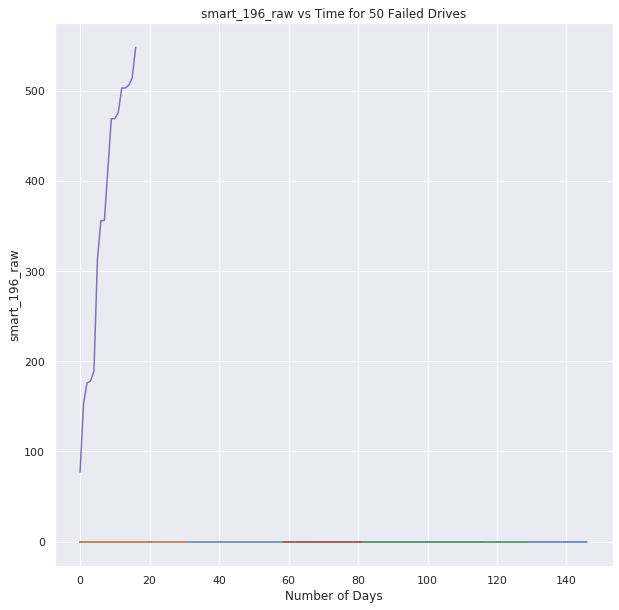

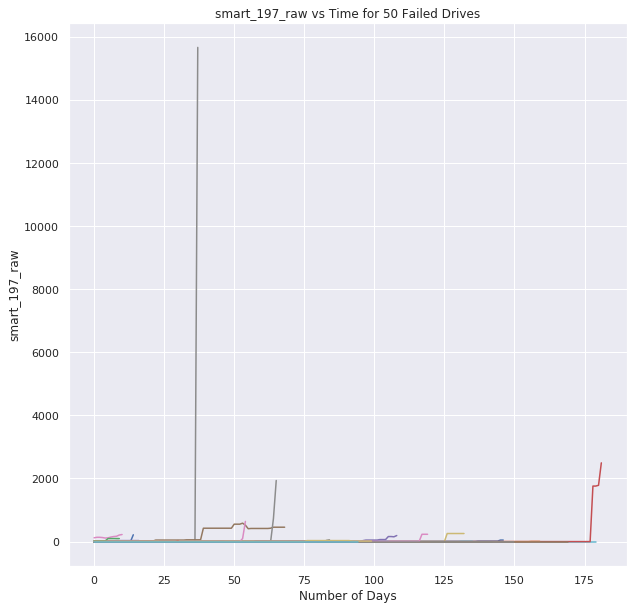

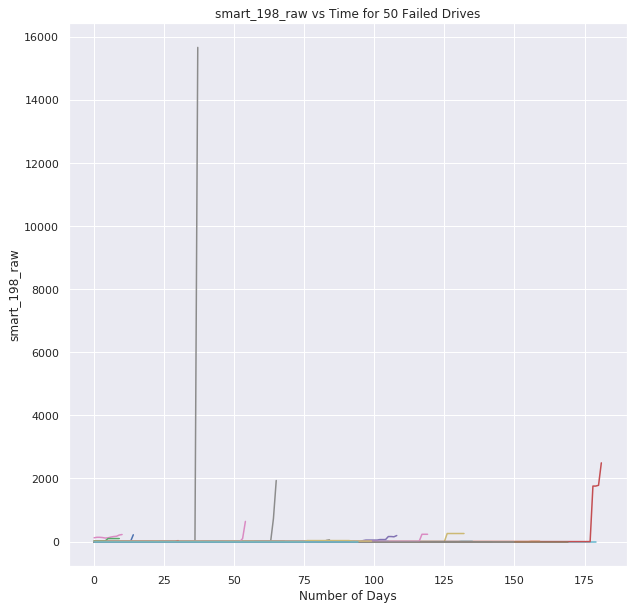

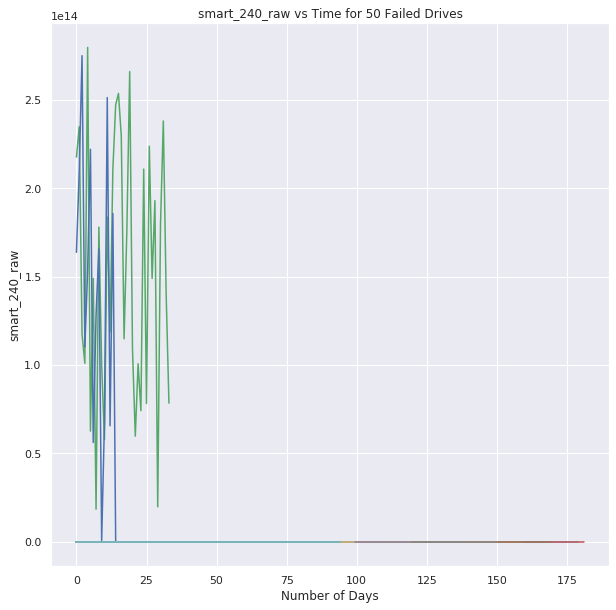

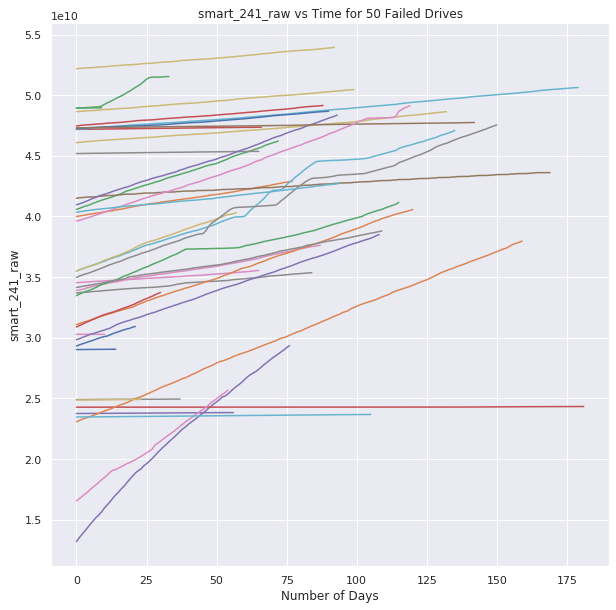

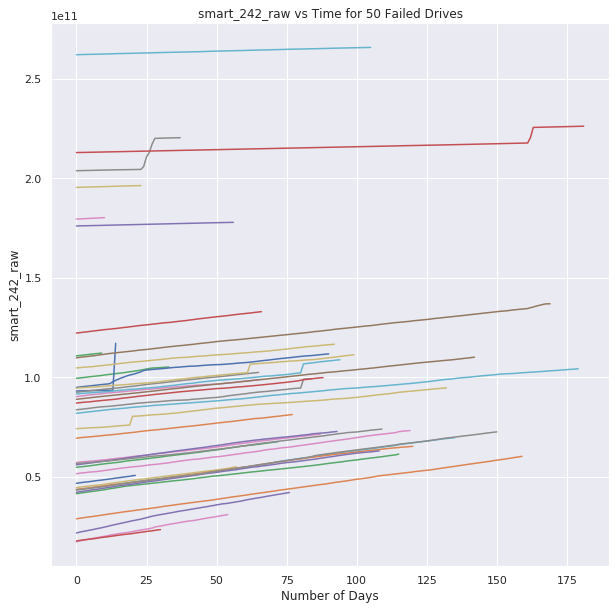

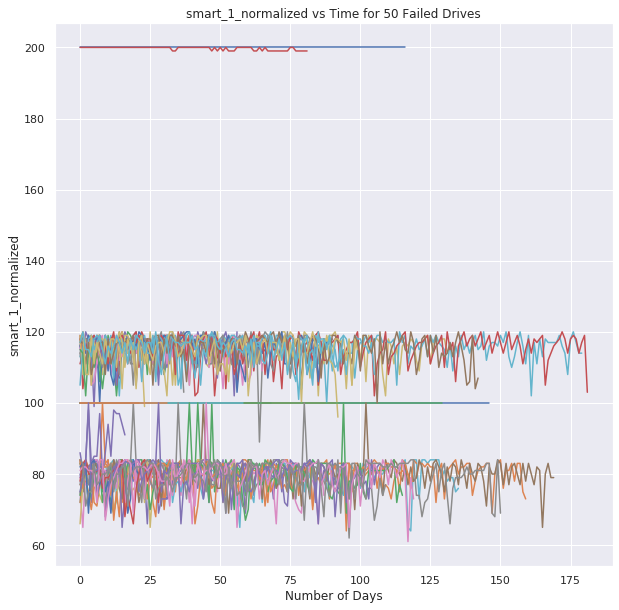

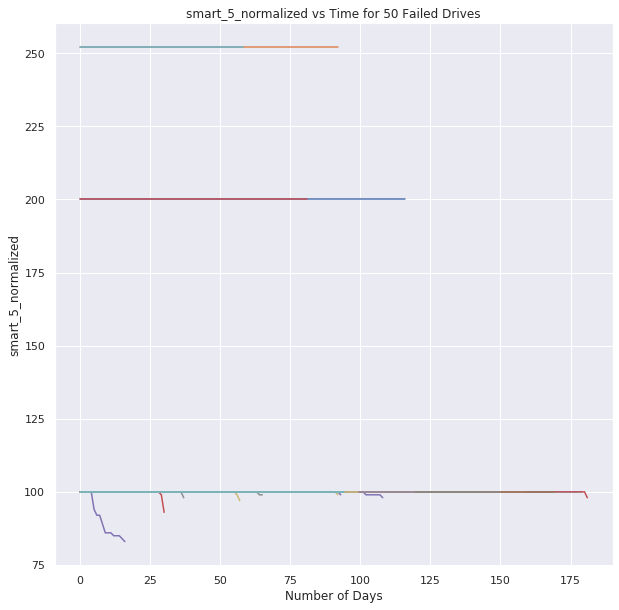

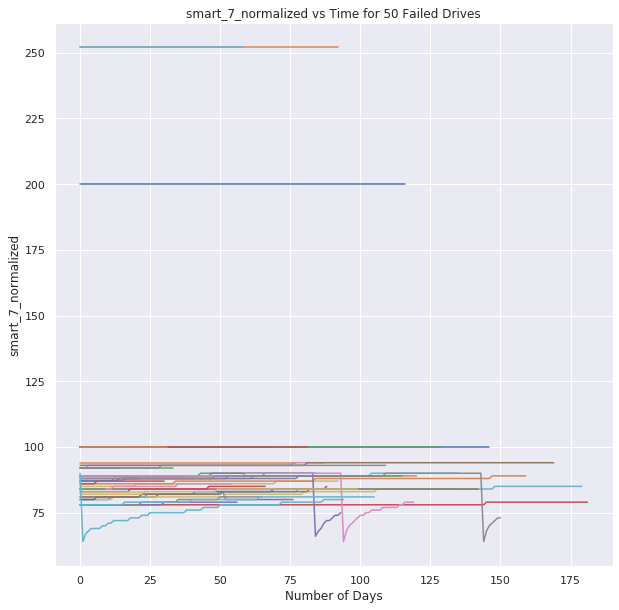

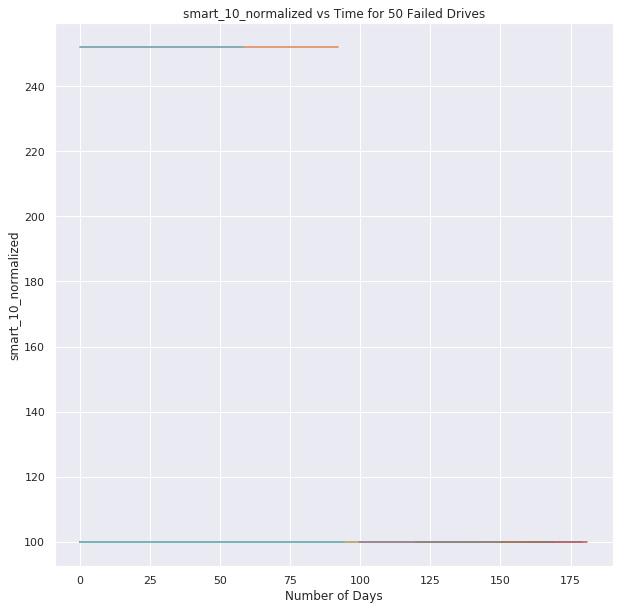

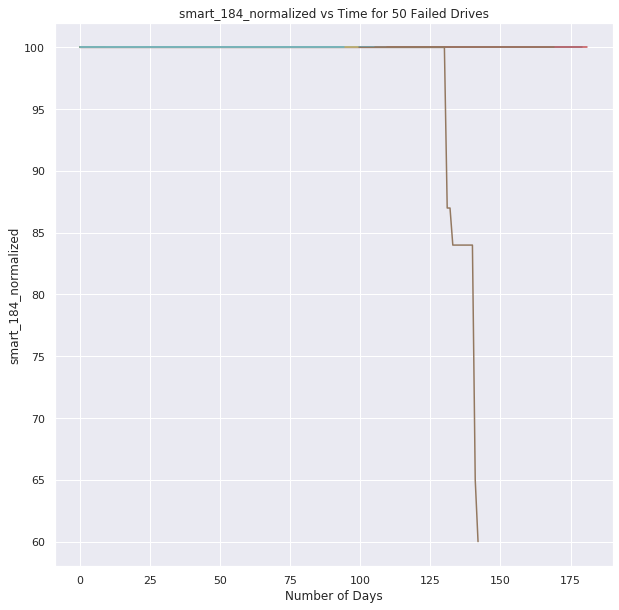

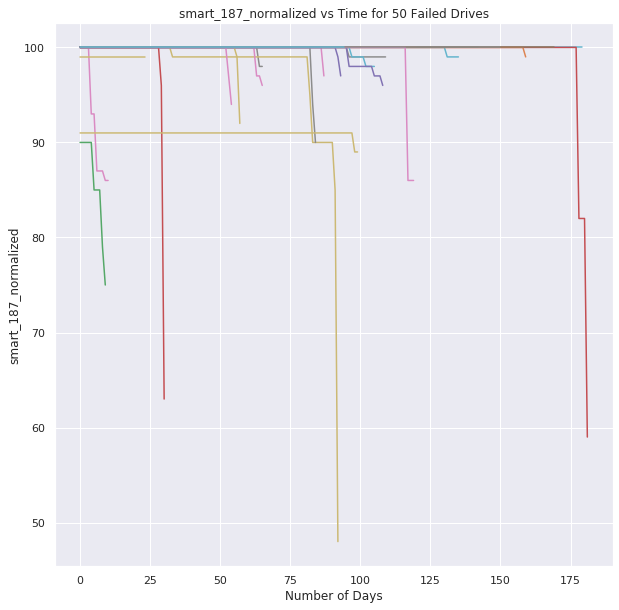

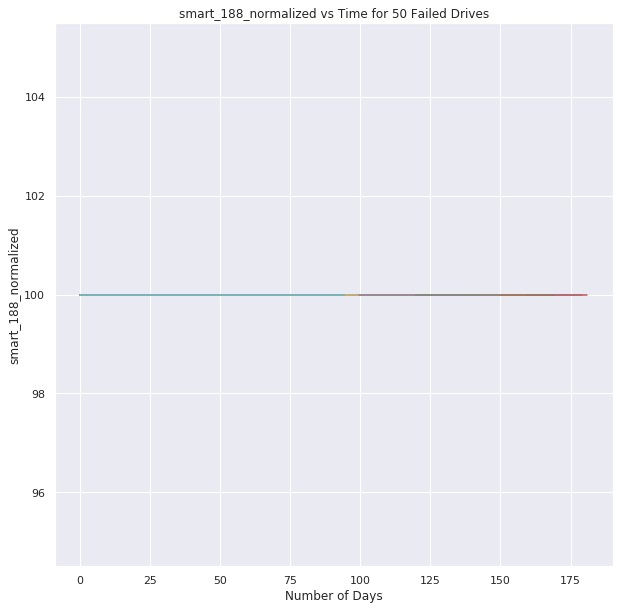

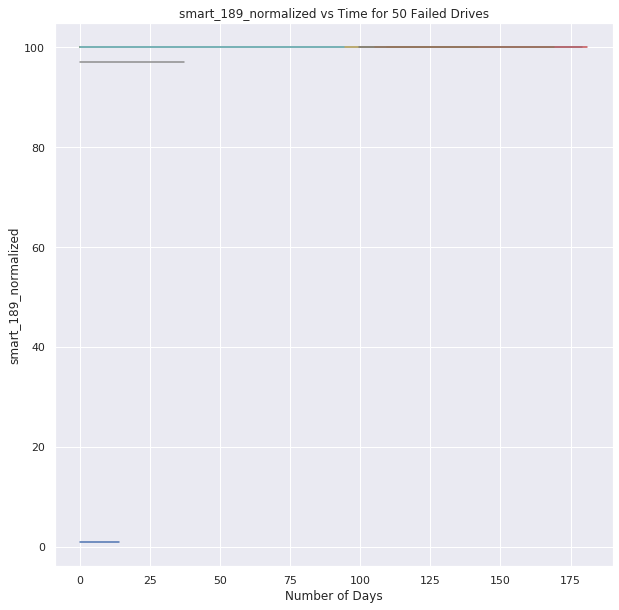

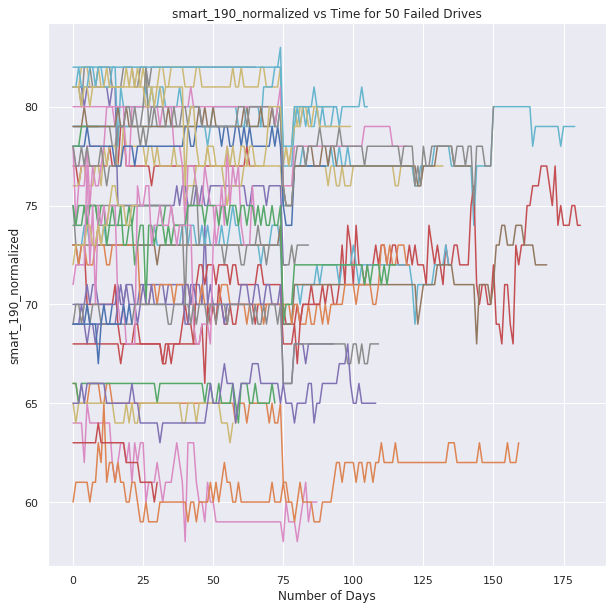

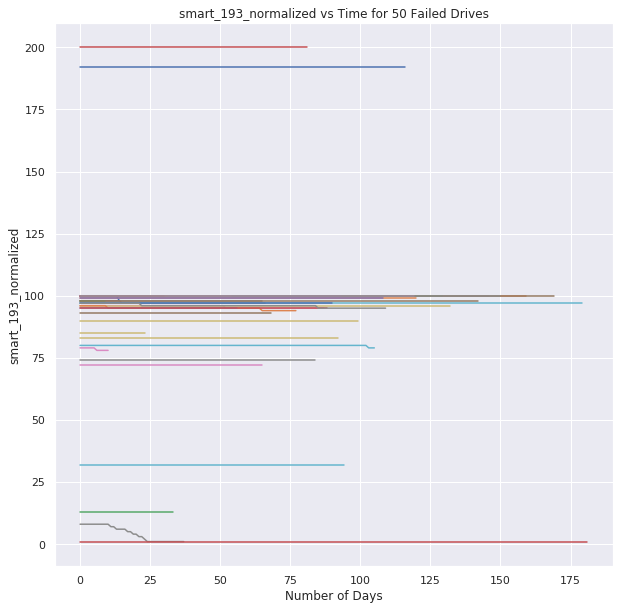

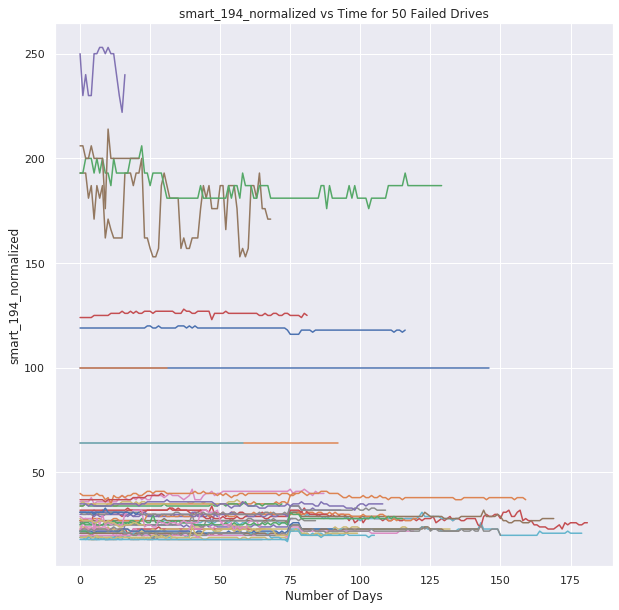

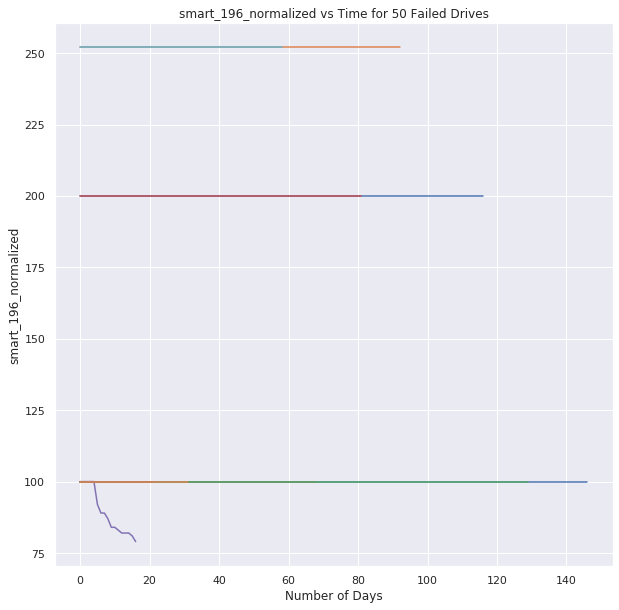

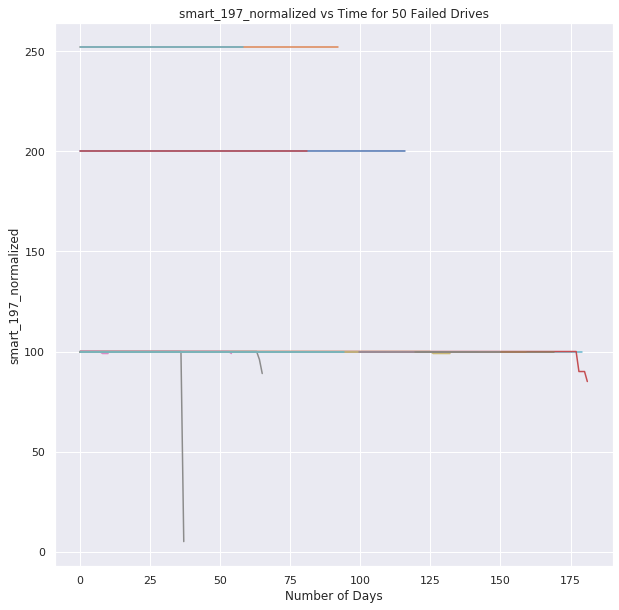

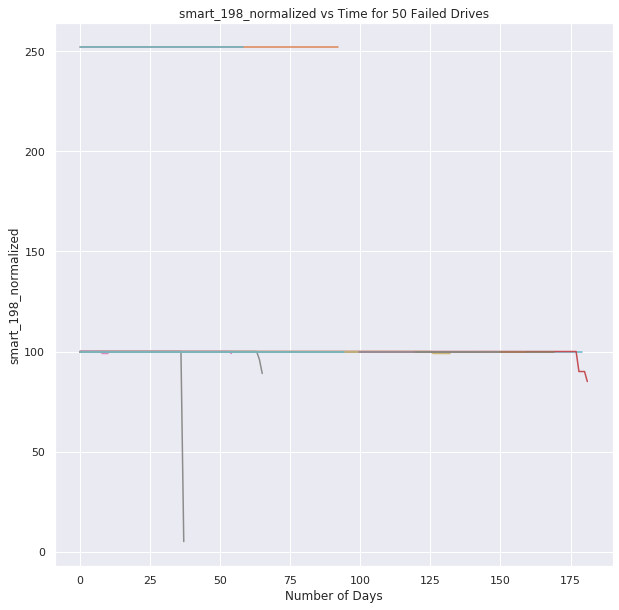

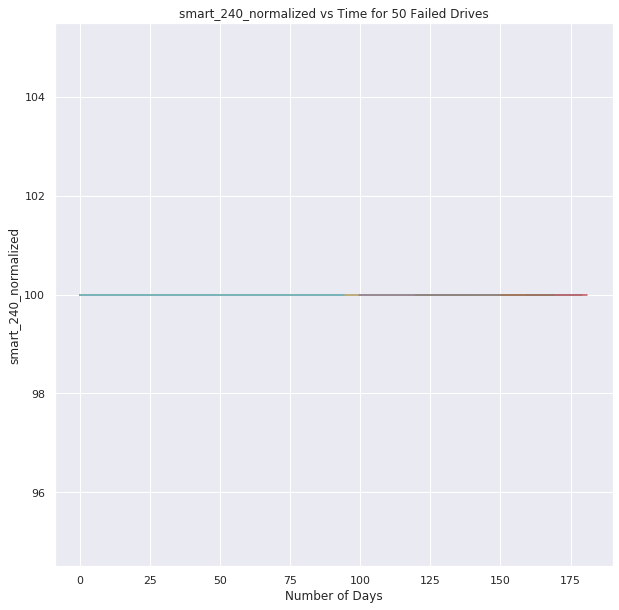

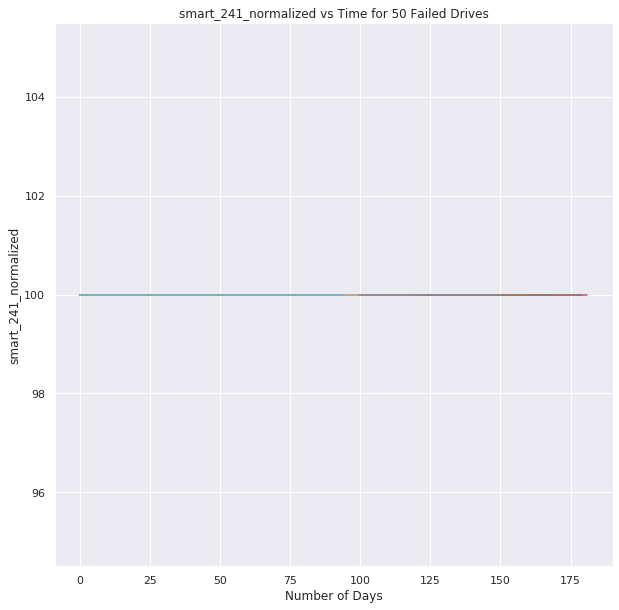

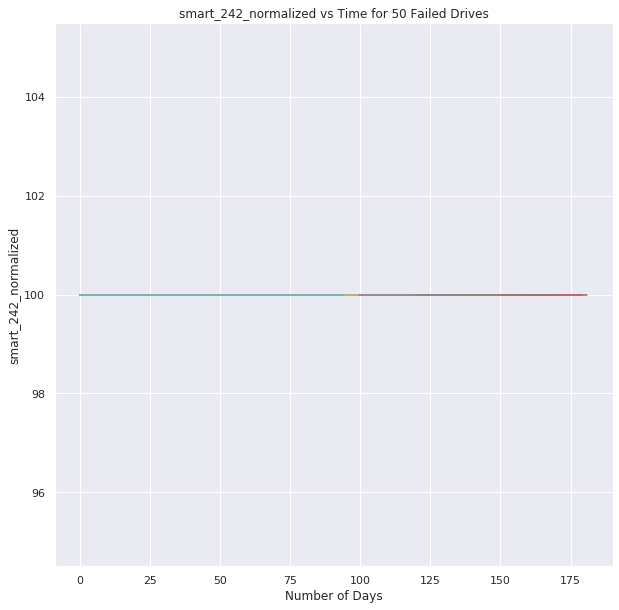

In [62]:
# TODO: Might be better to call compute to get the combined data of all serials in subset
# as opposed to calling it for earch serial number in for loop

# NOTE: running this cell will take a VERY long time (~1hr on intel i7 w/ 16GB ram)
# adjust NUM_DRIVES_TO_SAMPLE to select a small subset to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# plots for smart stat 5
# cols_to_plot = ['smart_5_raw', 'smart_7_raw']
cols_to_plot = crit_cols_raw + crit_cols_normalized
cols_to_plot.remove('smart_201_raw')            # too many nans
cols_to_plot.remove('smart_201_normalized')     # too many nans

# one figure per smart stat
figs = [plt.figure(i, figsize=(10, 10)) for i in range(len(cols_to_plot))]
axes = [f.add_subplot(111) for f in figs]
for colname, ax in zip(cols_to_plot, axes):
    ax.set_title('{} vs Time for {} Failed Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
failed_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(failed_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    failed_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_failed.png'.format(c))

# save the serial numbres used in figures
np.save('failed_graphs_serials', failed_ser_subset)

In [ ]:
# sample to use for plotting
NUM_DRIVES_TO_SAMPLE = 50

# one figure per smart stat
for colname, ax in zip(cols_to_plot, axes):
    ax.cla()    # clear data from previous plots
    ax.set_title('{} vs Time for {} Working Drives'.format(colname, NUM_DRIVES_TO_SAMPLE))
    ax.set_xlabel('Number of Days')
    ax.set_ylabel(colname)
    
# keep track of what hard drives were used to generate the data. NOTE: only the first 16 chars of ser will be saved
working_ser_subset = np.empty(shape=(NUM_DRIVES_TO_SAMPLE), dtype='<S16')

# make the figures
for i, ser in enumerate(working_serials['serial_number'].sample(NUM_DRIVES_TO_SAMPLE, random_state=42)):
    # log serial numbers which are being used
    working_ser_subset[i] = ser
    print('{} / {}. Drive serial number {}'.format(i + 1, NUM_DRIVES_TO_SAMPLE, ser))
    
    # get teh data to make the figures
    drive_data = df[df['serial_number']==ser][cols_to_plot].compute()
    
    # dummy x axis data
    xvals = [i for i in range(drive_data.shape[0])]
    
    # make the plot
    for ax, c in zip(axes, cols_to_plot):
        ax.plot(xvals, drive_data[c])

# save the figures
for f, c in zip(figs, cols_to_plot):
    f.savefig('img/{}_working.png'.format(c))

# save the serial numbres used in figures
np.save('working_graphs_serials', working_ser_subset)

In [ ]:
plt.close('all')

### Backblaze's analysis:

Backblaze also performed some analysis on the SMART stats 5, 187, 188, 197, 198. They concluded that just having one of the stats in an abnormal state may not necessarily mean anything, but all of them being abnormal at the same time is a red flag. Details and some nice diagrams can be found here: https://www.backblaze.com/blog/what-smart-stats-indicate-hard-drive-failures/

## Visualize Embeddings

In [42]:
from dask.distributed import Client
# from sklearn.externals.joblib import parallel_backend

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns

In [43]:
# get the groupby object. there should be one gourp per serial nunmbers
# get only those columns which have less than 50 percent nan values
grouped_data_cols = ['serial_number', 'model', 'capacity_bytes'] + list(nan_count.index[nan_count['percent'] < 0.5])
groups = df[grouped_data_cols].groupby('serial_number')

In [44]:
# get simple stats to represent time series of each hard drive
group_means = groups.mean().compute().add_prefix('mean_')
group_stds = groups.std().compute().add_prefix('std_')
# group_days = groups.size().compute().to_frame('days')
# group_days.index.name = None    # to match the other agg results, so that it can be concatenated easily

[########################################] | 100% Completed |  2min  4.9s
[########################################] | 100% Completed |  2min 13.3s
[########################################] | 100% Completed |  1min 40.6s


In [49]:
# put the stats together into one df
group_stats = pd.concat([group_means, group_stds], axis=1)

# make serial number a column instead of index. will be easier for calc later
group_stats = group_stats.reset_index()

# need to add failed label
group_stats['failure'] = group_stats['serial_number'].isin(failed_serials['serial_number'])

In [50]:
group_stats.head()

,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,...,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,failure
0,175PP3HDT,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
1,175PP3I4T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
2,175PP3I5T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
3,175PP3I6T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,False
4,175PP3I7T,5.001079e+11,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,True


In [51]:
# FIXME: find a smarter way to deal with nans. drop columns not rows
# for now, just drop it. this drops ~25k observations and leaves us with ~83k
clean_group_stats = group_stats.dropna(how='any')

# make sure we still have enough failure drive data
print(clean_group_stats['failure'].sum(), 'failed drives data retained')

clean_group_stats[clean_group_stats['failure']].head()

239 failed drives data retained


,serial_number,mean_capacity_bytes,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,...,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,failure
21754,S300VL9M,4.000787e+12,1.189357e+08,0.000000,3.852491e+08,0.0,0.0,0.000000,0.000000,0.0,...,0.022161,1.111080,0.01108,1.111025,0.022161,0.022161,0.022161,0.022161,0.022161,True
21850,S300WCLM,4.000787e+12,1.370316e+08,0.000000,2.904662e+08,0.0,0.0,3.250000,0.000000,0.0,...,0.000000,0.279310,0.00000,0.279310,0.000000,0.000000,0.000000,0.000000,0.000000,True
21955,S300WDLE,4.000787e+12,1.154199e+08,0.000000,5.503690e+07,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,1.050462,0.00000,1.050462,0.000000,0.000000,0.000000,0.000000,0.000000,True
22320,S300XB4V,4.000787e+12,1.168240e+08,0.000000,2.952973e+08,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.323381,0.00000,0.323381,0.000000,0.000000,0.000000,0.000000,0.000000,True
22472,S300XCWM,4.000787e+12,1.261164e+08,11.314286,8.620265e+07,0.0,0.0,2.257143,0.028571,0.0,...,0.000000,0.233791,0.00000,0.233791,0.000000,0.000000,0.000000,0.000000,0.000000,True


**NOTE** The percentage of failed hard drives retained is 312/393 = 0.79, and the percentage of healthy hard drives retained is 0.77. So in terms of NaN values dropped in the call in previous cell, the distribution is evenly spread across failed and healthy. (proportion of NaN is same)

In [52]:
# scale the data and find the top principal components
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42, whiten=True)\
        .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

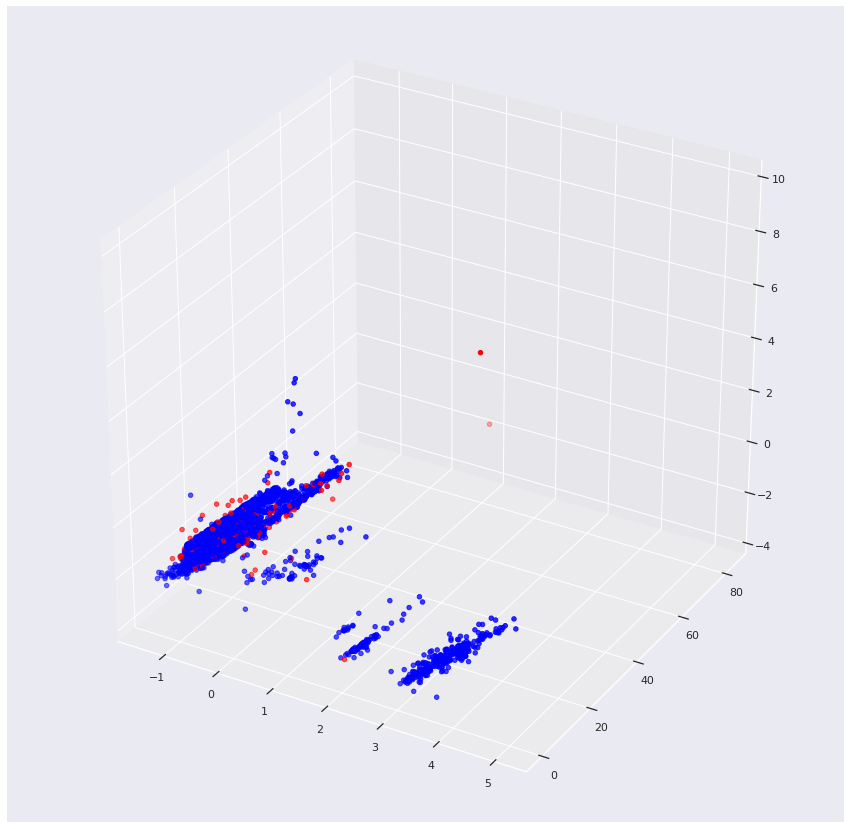

In [53]:
# plot pca
colors = ['blue', 'red']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca[:, 0],
           pca[:, 1],
           pca[:, 2],
           c=clean_group_stats['failure'],
           cmap=matplotlib.colors.ListedColormap(colors))

In [55]:
# plot umap
umap = UMAP(n_components=3, random_state=42)\
            .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/nu

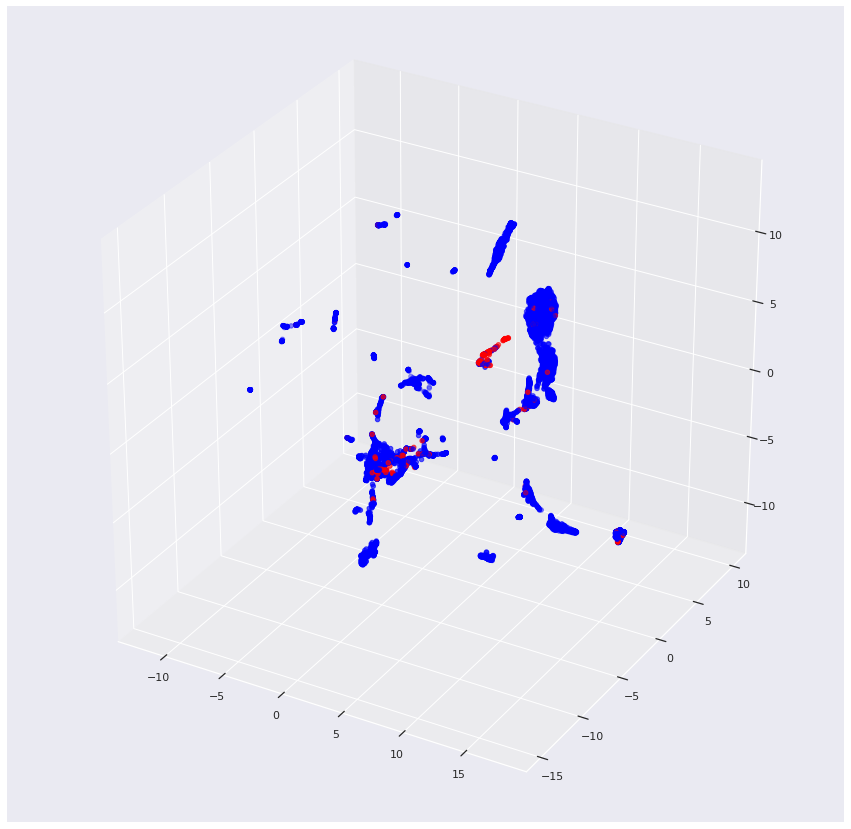

In [56]:
# plot umap
colors = ['blue', 'red']
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap[:, 0],
           umap[:, 1],
           umap[:, 2],
           c=clean_group_stats['failure'],
           cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
# tsne embeddings may be more meaningful than pca, but it is extremely slow
# tsne = TSNE(n_components=3, random_state=42)\
#         .fit_transform(scaler.fit_transform(clean_group_stats.drop(['serial_number', 'failure'], axis=1)))

## SMART 9 Behavior
SMART 9 represents number of power on hours. This can be indicative of lifespan and therefore be useable for the regression problem

In [57]:
# columns to extract from dataset for analyzing
analysis_cols = ['date', 'serial_number', 'smart_9_raw', 'smart_9_normalized']

# columns for which to make histogram
hist_cols = ['smart_9_raw', 'smart_9_normalized']

**NOTE**: The values above have entries from the same drive multiple times -- so it may not be a very good representation of how smart 9 generally is for failed drives. So, we try to get the max entry per serial number (assuming that that would be the latest entry) and plot histogram for that instead

In [58]:
# since failure=1 is marked on the last day that a drive worked, the entries on that day woudl be the most recent ones
# NOTE: this is a property of backblaze dataset, and may not generalize
failed_last_smart9_df = df[df['failure']==1][analysis_cols].compute()

[########################################] | 100% Completed |  1min 23.6s


In [59]:
# do the same for working drives
working_grouped = df[~df['serial_number'].isin(failed_serials)][hist_cols+['serial_number']].groupby('serial_number')
working_last_smart9_df = working_grouped.max()
dd.compute(working_last_smart9_df.shape)

[########################################] | 100% Completed |  1min 49.5s


((114472, 2),)

In [60]:
# size is not too bad -- we can bring it into memory
working_last_smart9_df = working_last_smart9_df.compute()

[########################################] | 100% Completed |  1min 44.2s


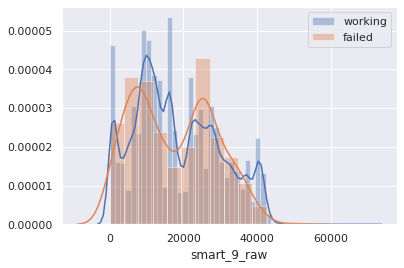

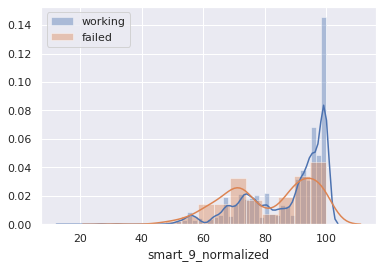

In [61]:
# working and failed plots together
for col in hist_cols:
    # get figure and axes for plotting current column
    fig, ax = plt.subplots()
    
    # plot failed and working onto the axes one by one
    data = working_last_smart9_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='working')
    data = failed_last_smart9_df[col]
    sns.distplot(data[~data.isna()], ax=ax, label='failed')
    plt.legend()
    plt.show()